<a href="https://colab.research.google.com/github/flyark/AFM-LIS/blob/main/alphafold3_local_interaction_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Local Interaction Score analysis with AlphaFold3 output

*   **Preprint**: Enhanced Protein-Protein Interaction Discovery via AlphaFold-Multimer. Kim et al (2024) [link](https://www.biorxiv.org/content/10.1101/2024.02.19.580970v1)
*   **GitHub**: https://github.com/flyark/AFM-LIS
*   **FlyPredictome**: AlphaFold-Multimer database for large-scale *Drosophila* PPI preditions (>100K). [link](https://www.flyrnai.org/tools/fly_predictome/web/)
*   The current note is based on [alphafold3_lis_contact_v0.15.ipynb](https://github.com/flyark/AFM-LIS/blob/main/alphafold3_lis_contact_v0.15.ipynb)


## Description about output

* LIA: the number of PAE coordinates that are less than PAE cutoff regardless of distance.
* LIS: the average of inversely scaled PAE (0 to 1, high better) within LIA.
* LIR: the number of residues involved in the interactions in LIA.
* cLIA: the number of PAE coordinates that are less than PAE cutoff within contact interface.
* cLIS: the average of inversely scaled PAE (0 to 1, high better) within cLIA.
* cLIR: the nubmer of residues involved in the interactions in cLIA.

## All results are averaged over two predictions.

For example, the result of protein 1 -> protein 2 and the result of protein 2 -> protein 1 are averaged.

## Acronyms

* LIA: Local Interaction Area
* LIS: Local Interaction Score
* LIR: Local Interaction Residue
* cLIA: contact Local Interaction Area
* cLIS: contact Local Interaction Score
* cLIR: contact Local Interaction Residue



# Installing and preparing LIS analysis

In [ ]:
#@title Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title Loading libraries and function for LIS analysis
!pip install biopython
import os
import re
import json
import warnings
import numpy as np
import pandas as pd
from Bio.PDB import MMCIFParser
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from collections import Counter
from scipy.spatial.distance import pdist, squareform

import matplotlib as mpl

warnings.filterwarnings('ignore')
np.seterr(divide='ignore', invalid='ignore')

def transform_pae_matrix(pae_matrix, pae_cutoff):
    # Initialize the transformed matrix with zeros
    transformed_pae = np.zeros_like(pae_matrix)

    # Apply transformation: pae = 0 -> score = 1, pae = cutoff -> score = 0, above cutoff -> score = 0
    # Linearly scale values between 0 and cutoff to fall between 1 and 0
    within_cutoff = pae_matrix < pae_cutoff
    transformed_pae[within_cutoff] = 1 - (pae_matrix[within_cutoff] / pae_cutoff)

    return transformed_pae

def calculate_mean_lis(transformed_pae, subunit_number):
    # Calculate the cumulative sum of protein lengths to get the end indices of the submatrices
    cum_lengths = np.cumsum(subunit_number)

    # Add a zero at the beginning of the cumulative lengths to get the start indices
    start_indices = np.concatenate(([0], cum_lengths[:-1]))

    # Initialize an empty matrix to store the mean LIS
    mean_lis_matrix = np.zeros((len(subunit_number), len(subunit_number)))

    # Iterate over the start and end indices
    for i in range(len(subunit_number)):
        for j in range(len(subunit_number)):
            # Get the start and end indices of the interaction submatrix
            start_i, end_i = start_indices[i], cum_lengths[i]
            start_j, end_j = start_indices[j], cum_lengths[j]

            # Get the interaction submatrix
            submatrix = transformed_pae[start_i:end_i, start_j:end_j]

            # Calculate the mean LIS, considering only non-zero values
            mean_lis = submatrix[submatrix > 0].mean()

            # Store the mean LIS in the matrix
            mean_lis_matrix[i, j] = mean_lis

    return mean_lis_matrix

def calculate_contact_map(cif_file, distance_threshold=8):
    def read_cif_lines(cif_path):
        with open(cif_path, 'r') as file:
            lines = file.readlines()

        residue_lines = []
        for line in lines:
            if line.startswith('ATOM') and ('CB' in line or 'GLY' in line and 'CA' in line):
                residue_lines.append(line.strip())  # Store the line if it meets the criteria for ATOM

            if line.startswith('ATOM') and 'P   ' in line:
                residue_lines.append(line.strip()) # Store the line if it meets the criteria for ATOM

            elif line.startswith('HETATM'):
                residue_lines.append(line.strip())  # Store all HETATM lines

        return residue_lines

    def lines_to_dataframe(residue_lines):
        # Split lines and create a list of dictionaries for each atom
        data = []
        for line in residue_lines:
            parts = line.split()
            # Correctly convert numerical values
            for i in range(len(parts)):
                try:
                    parts[i] = float(parts[i])
                except ValueError:
                    pass
            data.append(parts)

        df = pd.DataFrame(data)

        # Add line number column
        df.insert(0, 'residue', range(1, 1 + len(df)))

        return df

    # Read lines from CIF file
    residue_lines = read_cif_lines(cif_file)

    # Convert lines to DataFrame
    df = lines_to_dataframe(residue_lines)

    # Assuming the columns for x, y, z coordinates are at indices 11, 12, 13 after insertion
    coordinates = df.iloc[:, 11:14].to_numpy()

    distances = squareform(pdist(coordinates))

    # Assuming the column for atom names is at index 3 after insertion
    has_phosphorus = df.iloc[:, 3].apply(lambda x: 'P' in str(x)).to_numpy()

    # Adjust the threshold for phosphorus-containing residues
    adjusted_distances = np.where(has_phosphorus[:, np.newaxis] | has_phosphorus[np.newaxis, :],
                                  distances - 4, distances)

    contact_map = np.where(adjusted_distances < distance_threshold, 1, 0)
    return contact_map


def afm3_plot(af3_json, pae_cutoff=12, distance_cutoff=8.0):
    model_number = re.search(r'full_data_(\d+)', af3_json).group(1)
    json_data = json.load(open(af3_json,'rb'))
    token_chain_ids = json_data['token_chain_ids']
    chain_residue_counts = Counter(token_chain_ids)
    subunit_number = list(chain_residue_counts.values())
    pae_matrix = np.array(json_data['pae'])
    pae_matrix = np.nan_to_num(pae_matrix)
    subunit_sizes = subunit_number
    boundaries = np.cumsum(subunit_sizes)[:-1]

    # Extract the base name of the JSON file (without extension)
    json_basename = os.path.splitext(os.path.basename(af3_json))[0]
    pdb_basename = json_basename.replace('_full_data_', '_model_')

    # Construct CIF file path based on JSON file path
    base_path = os.path.dirname(af3_json)
    cif_file = os.path.join(base_path, f'{pdb_basename}.cif')

    # Create a figure with 1 row and 5 columns
    fig, axs = plt.subplots(1, 6, figsize=(30, 6))

    # Plotting the PAE matrix
    cax1 = axs[0].matshow(pae_matrix, cmap='bwr')
    for boundary in boundaries:
        axs[0].axvline(x=boundary, color='black', lw=1, linestyle='-')
        axs[0].axhline(y=boundary, color='black', lw=1, linestyle='-')

    fig.colorbar(cax1, ax=axs[0], label='Predicted Aligned Error (PAE)', shrink=0.5)
    axs[0].set_title(f'Model {model_number} Predicted Aligned Error Map')
    axs[0].xaxis.tick_bottom()

    # Transform the PAE matrix
    transformed_pae_matrix = transform_pae_matrix(pae_matrix, pae_cutoff)
    transformed_pae_matrix = np.nan_to_num(transformed_pae_matrix)

    # Plotting the transformed PAE matrix
    cax2 = axs[1].matshow(transformed_pae_matrix, cmap='Blues', vmin=0, vmax=1)
    for boundary in boundaries:
        axs[1].axvline(x=boundary, color='black', lw=1, linestyle='-')
        axs[1].axhline(y=boundary, color='black', lw=1, linestyle='-')

    fig.colorbar(cax2, ax=axs[1], label='Local Interaction Score (LIS)', shrink=0.5)
    axs[1].set_title(f'Model {model_number} Local Interaction Area Map')
    axs[1].xaxis.tick_bottom()

    # Calculate the mean LIS matrix
    mean_lis_matrix = calculate_mean_lis(transformed_pae_matrix, subunit_sizes)
    mean_lis_matrix = np.nan_to_num(mean_lis_matrix)

    # Plot the mean LIS matrix as a heatmap
    cax3 = axs[2].imshow(mean_lis_matrix, cmap='magma_r', interpolation='nearest', vmin=0, vmax=1)
    fig.colorbar(cax3, ax=axs[2], label='Local Interaction Score (LIS)', shrink=0.5)
    axs[2].set_title(f'Model {model_number} Local Interaction Score Heatmap')
    subunit_labels = [i for i in range(1, len(subunit_sizes)+1)]
    axs[2].set_xticks(np.arange(len(subunit_sizes)))
    axs[2].set_yticks(np.arange(len(subunit_sizes)))
    axs[2].set_xticklabels(subunit_labels)
    axs[2].set_yticklabels(subunit_labels)

    for i in range(len(subunit_sizes)):
        for j in range(len(subunit_sizes)):
            value = mean_lis_matrix[i, j]
            text_color = 'w' if value > 0.5 else 'k'
            axs[2].text(j, i, format(mean_lis_matrix[i, j], '.3f'), ha='center', va='center', color=text_color)

    # Calculate contact map
    contact_map = calculate_contact_map(cif_file, distance_cutoff)

    # Create a new map that combines the inverse PAE map with the contact map
    combined_map = np.where((transformed_pae_matrix > 0) & (contact_map == 1), transformed_pae_matrix, 0)

    # Plotting the transformed PAE matrix
    cax4 = axs[3].matshow(combined_map, cmap='Reds', vmin=0, vmax=1)
    for boundary in boundaries:
        axs[3].axvline(x=boundary, color='black', lw=1, linestyle='-')
        axs[3].axhline(y=boundary, color='black', lw=1, linestyle='-')

    fig.colorbar(cax4, ax=axs[3], label='Contact Local Interaction Score (cLIS)', shrink=0.5)
    axs[3].xaxis.tick_bottom()
    axs[3].set_title(f'Model {model_number} Contact Local Interaction Area Map')

    # Calculate the mean LIS matrix
    mean_clis_matrix = calculate_mean_lis(combined_map, subunit_sizes)
    mean_clis_matrix = np.nan_to_num(mean_clis_matrix)

    # Plot the mean cLIS matrix as a heatmap
    cax5 = axs[4].imshow(mean_clis_matrix, cmap='magma_r', interpolation='nearest', vmin=0, vmax=1)
    fig.colorbar(cax5, ax=axs[4], label='Contact Local Interaction Score (cLIS)', shrink=0.5)
    axs[4].set_title(f'Model {model_number} Contact Local Interaction Score Heatmap')
    subunit_labels = [i for i in range(1, len(subunit_sizes)+1)]
    axs[4].set_xticks(np.arange(len(subunit_sizes)))
    axs[4].set_yticks(np.arange(len(subunit_sizes)))
    axs[4].set_xticklabels(subunit_labels)
    axs[4].set_yticklabels(subunit_labels)

    for i in range(len(subunit_sizes)):
        for j in range(len(subunit_sizes)):
            value = mean_clis_matrix[i, j]
            text_color = 'w' if value > 0.5 else 'k'
            axs[4].text(j, i, format(mean_clis_matrix[i, j], '.3f'), ha='center', va='center', color=text_color)

    json_confidence = af3_json.replace('full_data', 'summary_confidences')
    with open(json_confidence, 'r') as file:
        confidence_data = json.load(file)

    iptm_matrix = confidence_data['chain_pair_iptm']

    iptm_matrix = np.array(iptm_matrix, dtype=float)  # Converts None to np.nan automatically
    iptm_matrix = np.nan_to_num(iptm_matrix)
    cax6 = axs[5].imshow(iptm_matrix, cmap='Greens', vmin = 0, vmax = 1, interpolation='nearest')
    fig.colorbar(cax6, ax=axs[5], label='ipTM', shrink=0.5)
    axs[5].set_title(f'Model {model_number} ipTM Heatmap')

    # Set the ticks to start from 1 and be integers
    ticks = np.arange(1, iptm_matrix.shape[0] + 1)
    axs[5].set_xticks(ticks - 1)
    axs[5].set_yticks(ticks - 1)
    axs[5].set_xticklabels(ticks)
    axs[5].set_yticklabels(ticks)

    # Display the values of the IPTM matrix on the heatmap
    for i in range(iptm_matrix.shape[0]):
        for j in range(iptm_matrix.shape[1]):
            value = iptm_matrix[i, j]
            if np.isnan(value):
                continue  # Skip NaN values
            text_color = 'w' if value > 0.7 else 'k'

            axs[5].text(j, i, format(value, '.3f'), ha='center', va='center', color=text_color)

    plt.tight_layout()
    plt.show()

def load_and_plot_heatmap(json_file):
    # Step 1: Load JSON file
    with open(json_file, 'r') as file:
        data = json.load(file)

    # Step 2: Extract IPTM matrix
    iptm_matrix = data['chain_pair_iptm']

    # Step 3: Convert None to np.nan (or any other value you prefer)
    iptm_matrix = np.array(iptm_matrix, dtype=float)  # Converts None to np.nan automatically

    # Step 4: Create heatmap
    plt.figure(figsize=(10, 8))
    plt.imshow(iptm_matrix, cmap='viridis', vmin = 0, vmax = 1, interpolation='nearest')
    plt.colorbar(label='ipTM')
    plt.title('Heatmap of IPTM')
    # plt.xlabel('Chain Index')
    # plt.ylabel('Chain Index')
    plt.show()


def generate_json_paths(base_path, number_of_models=5):
    """
    Generates a list of JSON file paths for a given number of models within a specified base path.

    Parameters:
    - base_path (str): The base directory where the model JSON files are stored.
    - number_of_models (int): The number of model JSON files to generate paths for.

    Returns:
    - list: A list of fully qualified paths to the JSON files.
    """
    model_identifier = os.path.basename(base_path)
    json_files = [f"{base_path}/{model_identifier}_full_data_{model}.json" for model in range(number_of_models)]
    return json_files

def afm3_plot_average(af3_jsons, pae_cutoff=12, distance_cutoff=8):
    # Initialize the sum of PAE matrices, transformed PAE matrices, mean LIS matrices, and contact maps
    sum_pae_matrix = None
    sum_transformed_pae_matrix = None
    sum_mean_lis_matrix = None
    sum_contact_lia_map = None
    sum_iptm_matrix = None

    for af3_json in af3_jsons:
        json_data = json.load(open(af3_json,'rb'))
        json_confidence = af3_json.replace('full_data', 'summary_confidences')
        confidence_data = json.load(open(json_confidence, 'rb'))
        token_chain_ids = json_data['token_chain_ids']
        chain_residue_counts = Counter(token_chain_ids)
        subunit_number = list(chain_residue_counts.values())
        pae_matrix = np.array(json_data['pae'])
        subunit_sizes = subunit_number

        cif_file = af3_json.replace('_full_data_', '_model_').replace('.json', '.cif')

        # Transform the PAE matrix
        transformed_pae_matrix = transform_pae_matrix(pae_matrix, pae_cutoff)
        transformed_pae_matrix = np.nan_to_num(transformed_pae_matrix)

        # Calculate the mean LIS matrix
        mean_lis_matrix = calculate_mean_lis(transformed_pae_matrix, subunit_sizes)
        mean_lis_matrix = np.nan_to_num(mean_lis_matrix)

        contact_map = calculate_contact_map(cif_file, distance_cutoff)
        combined_map = np.where((transformed_pae_matrix > 0) & (contact_map == 1), transformed_pae_matrix, 0)

        iptm_matrix = confidence_data['chain_pair_iptm']
        iptm_matrix = np.array(iptm_matrix, dtype=float)  # Converts None to np.nan automatically
        iptm_matrix = np.nan_to_num(iptm_matrix)

        # Add the matrices to the sum
        if sum_pae_matrix is None:
            sum_pae_matrix = pae_matrix
            sum_transformed_pae_matrix = transformed_pae_matrix
            sum_mean_lis_matrix = mean_lis_matrix
            sum_contact_lia_map = combined_map
            sum_iptm_matrix = iptm_matrix
        else:
            sum_pae_matrix += pae_matrix
            sum_transformed_pae_matrix += transformed_pae_matrix
            sum_mean_lis_matrix += mean_lis_matrix
            sum_contact_lia_map += combined_map
            sum_iptm_matrix += iptm_matrix

    # Calculate the average matrices
    avg_pae_matrix = sum_pae_matrix / len(af3_jsons)
    avg_transformed_pae_matrix = sum_transformed_pae_matrix / len(af3_jsons)
    avg_mean_lis_matrix = sum_mean_lis_matrix / len(af3_jsons)
    sum_contact_lia_map = sum_contact_lia_map / len(af3_jsons)
    avg_iptm_matrix = sum_iptm_matrix / len(af3_jsons)

    # Replace nan with 0
    avg_pae_matrix = np.nan_to_num(avg_pae_matrix)
    avg_transformed_pae_matrix = np.nan_to_num(avg_transformed_pae_matrix)
    avg_mean_lis_matrix = np.nan_to_num(avg_mean_lis_matrix)
    avg_iptm_matrix = np.nan_to_num(avg_iptm_matrix)

    # Create a figure with 1 row and 5 columns
    fig, axs = plt.subplots(1, 6, figsize=(30, 5))

    # Calculate the cumulative sum of subunit sizes to get the boundaries
    boundaries = np.cumsum(subunit_sizes)[:-1]

    # Plotting the average PAE matrix
    cax1 = axs[0].matshow(avg_pae_matrix, cmap='bwr')
    fig.colorbar(cax1, ax=axs[0], label='Average Predicted Aligned Error (PAE)', shrink=0.5)
    axs[0].set_title('Average Predicted Aligned Error Map')
    axs[0].xaxis.tick_bottom()

    # Add vertical and horizontal lines at the boundaries
    for boundary in boundaries:
        axs[0].axvline(x=boundary, color='black', lw=1, linestyle='-')
        axs[0].axhline(y=boundary, color='black', lw=1, linestyle='-')

    # Plotting the average transformed PAE matrix
    cax2 = axs[1].matshow(avg_transformed_pae_matrix, cmap='Blues', vmin=0, vmax=1)
    fig.colorbar(cax2, ax=axs[1], label='Average Local Interaction Score (LIS)', shrink=0.5)
    axs[1].set_title('Average Local Interaction Area Map')
    axs[1].xaxis.tick_bottom()

    # Add vertical and horizontal lines at the boundaries
    for boundary in boundaries:
        axs[1].axvline(x=boundary, color='black', lw=1, linestyle='-')
        axs[1].axhline(y=boundary, color='black', lw=1, linestyle='-')

    # Plot the average mean LIS matrix as a heatmap
    cax3 = axs[2].imshow(avg_mean_lis_matrix, cmap='magma_r', interpolation='nearest', vmin=0, vmax=1)
    fig.colorbar(cax3, ax=axs[2], label='Average Local Interaction Score (LIS)', shrink=0.5)
    axs[2].set_title('Average Local Interaction Score Heatmap')
    subunit_labels = [i for i in range(1, len(subunit_sizes)+1)]
    axs[2].set_xticks(np.arange(len(subunit_sizes)))
    axs[2].set_yticks(np.arange(len(subunit_sizes)))
    axs[2].set_xticklabels(subunit_labels)
    axs[2].set_yticklabels(subunit_labels)

    for i in range(len(subunit_sizes)):
        for j in range(len(subunit_sizes)):
            value = avg_mean_lis_matrix[i, j]
            text_color = 'w' if value > 0.5 else 'k'
            axs[2].text(j, i, format(value, '.3f'), ha='center', va='center', color=text_color)


    # Plotting the average mean contact LIS PAE matrix
    cax4 = axs[3].matshow(sum_contact_lia_map, cmap='Reds', vmin=0, vmax=1)
    for boundary in boundaries:
        axs[3].axvline(x=boundary, color='black', lw=1, linestyle='-')
        axs[3].axhline(y=boundary, color='black', lw=1, linestyle='-')

    fig.colorbar(cax4, ax=axs[3], label='Average Contact Local Interaction Score (cLIS)', shrink=0.5)
    axs[3].xaxis.tick_bottom()
    axs[3].set_title(f'Average Contact Local Interaction Area Map')

    # Calculate the mean LIS matrix
    mean_clis_matrix = calculate_mean_lis(sum_contact_lia_map, subunit_sizes)
    mean_clis_matrix = np.nan_to_num(mean_clis_matrix)

    # Plot the mean cLIS matrix as a heatmap
    cax5 = axs[4].imshow(mean_clis_matrix, cmap='magma_r', interpolation='nearest', vmin=0, vmax=1)
    fig.colorbar(cax5, ax=axs[4], label='Average Contact Local Interaction Score (cLIS)', shrink=0.5)
    axs[4].set_title(f'Average Contact Local Interaction Score Heatmap')
    subunit_labels = [i for i in range(1, len(subunit_sizes)+1)]
    axs[4].set_xticks(np.arange(len(subunit_sizes)))
    axs[4].set_yticks(np.arange(len(subunit_sizes)))
    axs[4].set_xticklabels(subunit_labels)
    axs[4].set_yticklabels(subunit_labels)

    for i in range(len(subunit_sizes)):
        for j in range(len(subunit_sizes)):
            value = mean_clis_matrix[i, j]
            text_color = 'w' if value > 0.5 else 'k'
            axs[4].text(j, i, format(mean_clis_matrix[i, j], '.3f'), ha='center', va='center', color=text_color)


    cax6 = axs[5].imshow(avg_iptm_matrix, cmap='Greens', vmin = 0, vmax = 1, interpolation='nearest')
    fig.colorbar(cax6, ax=axs[5], label='ipTM', shrink=0.5)
    axs[5].set_title(f'Average ipTM Heatmap')

    # Set the ticks to start from 1 and be integers
    ticks = np.arange(1, avg_iptm_matrix.shape[0] + 1)
    axs[5].set_xticks(ticks - 1)
    axs[5].set_yticks(ticks - 1)
    axs[5].set_xticklabels(ticks)
    axs[5].set_yticklabels(ticks)

    # Display the values of the IPTM matrix on the heatmap
    for i in range(avg_iptm_matrix.shape[0]):
        for j in range(avg_iptm_matrix.shape[1]):
            value = avg_iptm_matrix[i, j]
            if np.isnan(value):
                continue  # Skip NaN values
            text_color = 'w' if value > 0.7 else 'k'
            axs[5].text(j, i, format(value, '.3f'), ha='center', va='center', color=text_color)

    plt.tight_layout()
    plt.show()

def afm3_plot_average_to_df(af3_jsons, pae_cutoff=12, distance_cutoff=8, result_save = "True"):
    sum_pae_matrix = None
    sum_transformed_pae_matrix = None
    sum_mean_lis_matrix = None
    sum_contact_lia_map = None
    sum_iptm_matrix = None
    all_interactions = []

    for af3_json in af3_jsons:
        json_data = json.load(open(af3_json, 'rb'))
        json_confidence = af3_json.replace('full_data', 'summary_confidences')
        confidence_data = json.load(open(json_confidence, 'rb'))
        token_chain_ids = json_data['token_chain_ids']
        chain_residue_counts = Counter(token_chain_ids)
        subunit_number = list(chain_residue_counts.values())
        pae_matrix = np.array(json_data['pae'])
        subunit_sizes = subunit_number

        cif_file = af3_json.replace('_full_data_', '_model_').replace('.json', '.cif')

        transformed_pae_matrix = transform_pae_matrix(pae_matrix, pae_cutoff)
        transformed_pae_matrix = np.nan_to_num(transformed_pae_matrix)
        lia_map = np.where(transformed_pae_matrix > 0, 1, 0)

        mean_lis_matrix = calculate_mean_lis(transformed_pae_matrix, subunit_sizes)
        mean_lis_matrix = np.nan_to_num(mean_lis_matrix)

        contact_map = calculate_contact_map(cif_file, distance_cutoff)
        combined_map = np.where((transformed_pae_matrix > 0) & (contact_map == 1), transformed_pae_matrix, 0)

        mean_clis_matrix = calculate_mean_lis(combined_map, subunit_sizes)
        mean_clis_matrix = np.nan_to_num(mean_clis_matrix)

        lia_matrix = np.zeros((len(subunit_sizes), len(subunit_sizes)))
        lir_matrix = np.zeros((len(subunit_sizes), len(subunit_sizes)))
        clia_matrix = np.zeros((len(subunit_sizes), len(subunit_sizes)))
        clir_matrix = np.zeros((len(subunit_sizes), len(subunit_sizes)))

        for i in range(len(subunit_sizes)):
            for j in range(len(subunit_sizes)):
                start_i, end_i = sum(subunit_sizes[:i]), sum(subunit_sizes[:i+1])
                start_j, end_j = sum(subunit_sizes[:j]), sum(subunit_sizes[:j+1])
                interaction_submatrix = lia_map[start_i:end_i, start_j:end_j]

                lia_matrix[i, j] = int(np.count_nonzero(interaction_submatrix))
                residues_i = np.unique(np.where(interaction_submatrix > 0)[0]) + start_i
                residues_j = np.unique(np.where(interaction_submatrix > 0)[1]) + start_j
                lir_matrix[i, j] = int(len(residues_i) + len(residues_j))

                combined_submatrix = combined_map[start_i:end_i, start_j:end_j]
                clia_matrix[i, j] = int(np.count_nonzero(combined_submatrix))

                residues_i = np.unique(np.where(combined_submatrix > 0)[0]) + start_i
                residues_j = np.unique(np.where(combined_submatrix > 0)[1]) + start_j
                clir_matrix[i, j] = int(len(residues_i) + len(residues_j))

        iptm_matrix = confidence_data['chain_pair_iptm']
        iptm_matrix = np.array(iptm_matrix, dtype=float)
        iptm_matrix = np.nan_to_num(iptm_matrix)

        if sum_pae_matrix is None:
            sum_pae_matrix = pae_matrix
            sum_transformed_pae_matrix = transformed_pae_matrix
            sum_mean_lis_matrix = mean_lis_matrix
            sum_contact_lia_map = combined_map
            sum_iptm_matrix = iptm_matrix
        else:
            sum_pae_matrix += pae_matrix
            sum_transformed_pae_matrix += transformed_pae_matrix
            sum_mean_lis_matrix += mean_lis_matrix
            sum_contact_lia_map += combined_map
            sum_iptm_matrix += iptm_matrix

        model_number = re.search(r'full_data_(\d+)', af3_json).group(1)
        folder_name = os.path.basename(os.path.dirname(af3_json))
        for i in range(len(subunit_sizes)):
            for j in range(len(subunit_sizes)):
                interaction = {
                    'folder_name': folder_name,
                    'model_number': model_number,
                    'protein_1': i + 1,
                    'protein_2': j + 1,
                    'LIS': mean_lis_matrix[i, j],
                    'LIA': lia_matrix[i, j],
                    'LIR': lir_matrix[i, j],
                    'cLIS': mean_clis_matrix[i, j],
                    'cLIA': clia_matrix[i, j],
                    'cLIR': clir_matrix[i, j],
                    'iptm': iptm_matrix[i, j],
                }
                all_interactions.append(interaction)

    avg_pae_matrix = sum_pae_matrix / len(af3_jsons)
    avg_transformed_pae_matrix = sum_transformed_pae_matrix / len(af3_jsons)
    avg_mean_lis_matrix = sum_mean_lis_matrix / len(af3_jsons)
    avg_contact_lia_map = sum_contact_lia_map / len(af3_jsons)
    avg_iptm_matrix = sum_iptm_matrix / len(af3_jsons)

    avg_pae_matrix = np.nan_to_num(avg_pae_matrix)
    avg_transformed_pae_matrix = np.nan_to_num(avg_transformed_pae_matrix)
    avg_mean_lis_matrix = np.nan_to_num(avg_mean_lis_matrix)
    avg_iptm_matrix = np.nan_to_num(avg_iptm_matrix)

    df_interactions = pd.DataFrame(all_interactions)
    df_interactions['interaction'] = df_interactions.apply(lambda row: tuple(sorted((row['protein_1'], row['protein_2']))), axis=1)
    df_merged = df_interactions.groupby(['folder_name', 'model_number', 'interaction']).mean().reset_index()
    df_merged[['protein_1', 'protein_2']] = pd.DataFrame(df_merged['interaction'].tolist(), index=df_merged.index)
    df_merged = df_merged.drop(columns=['interaction'])

    # Calculate average values for each protein pair and add as new rows
    avg_rows = []
    interaction_pairs = df_merged.groupby(['protein_1', 'protein_2'])

    for (protein_1, protein_2), group in interaction_pairs:
        avg_row = {
            'folder_name': folder_name,
            'model_number': 'average',
            'protein_1': protein_1,
            'protein_2': protein_2,
            'LIS': group['LIS'].mean(),
            'LIA': group['LIA'].mean(),
            'LIR': group['LIR'].mean(),
            'cLIS': group['cLIS'].mean(),
            'cLIA': group['cLIA'].mean(),
            'cLIR': group['cLIR'].mean(),
            'iptm': group['iptm'].mean(),
        }
        avg_rows.append(avg_row)

    df_avg = pd.DataFrame(avg_rows)
    df_merged = pd.concat([df_merged, df_avg], ignore_index=True)

    df_merged['LIA'] = df_merged['LIA'].astype(int)
    df_merged['LIR'] = df_merged['LIR'].astype(int)
    df_merged['cLIA'] = df_merged['cLIA'].astype(int)
    df_merged['cLIR'] = df_merged['cLIR'].astype(int)

    # Save DataFrame to CSV
    output_folder = os.path.dirname(af3_jsons[0])
    output_path = os.path.join(output_folder, f"{folder_name}_lis_analysis.csv")
    if result_save == "True":
        df_merged.to_csv(output_path, index=False)
        print("Results saved to: ", output_path)
        print(f"{folder_name}_lis_analysis.csv")

    return df_merged


# Uploading AF3 output to Google Drive

In [ ]:
#@title Find AF3 output and upload AF3 **zip** file


from google.colab import files
import os
import shutil
import zipfile

# Step 1: Upload the File
uploaded = files.upload()

# Step 2: Create the target directory if it doesn't exist
target_directory_base = '/content/alphafold3'
os.makedirs(target_directory_base, exist_ok=True)

# Step 3: Move the uploaded file to the base target directory
for filename in uploaded.keys():
    shutil.move(filename, os.path.join(target_directory_base, filename))

# Initialize the base_path variable
base_path = None

# Step 4: Unzip the file into a new directory named after the zip file (without .zip extension)
for filename in uploaded.keys():
    if filename.endswith('.zip'):
        # Create a directory named after the zip file (without .zip extension)
        extract_directory = os.path.join(target_directory_base, filename[:-4])
        os.makedirs(extract_directory, exist_ok=True)

        # Unzip the file into the new directory
        with zipfile.ZipFile(os.path.join(target_directory_base, filename), 'r') as zip_ref:
            zip_ref.extractall(extract_directory)

        # Set base_path to the directory containing the unzipped files
        base_path = extract_directory

# Step 5: List files in the base target directory and the newly created directory
print(f"Unzipped files in '{base_path}':")



# Proceed the below cell by Shift+Enter


*   Individual plots can be downloaded by righ+mouse click
*   LIS output csv file is saved in individual af3 output folder in '/content/alphafold3'



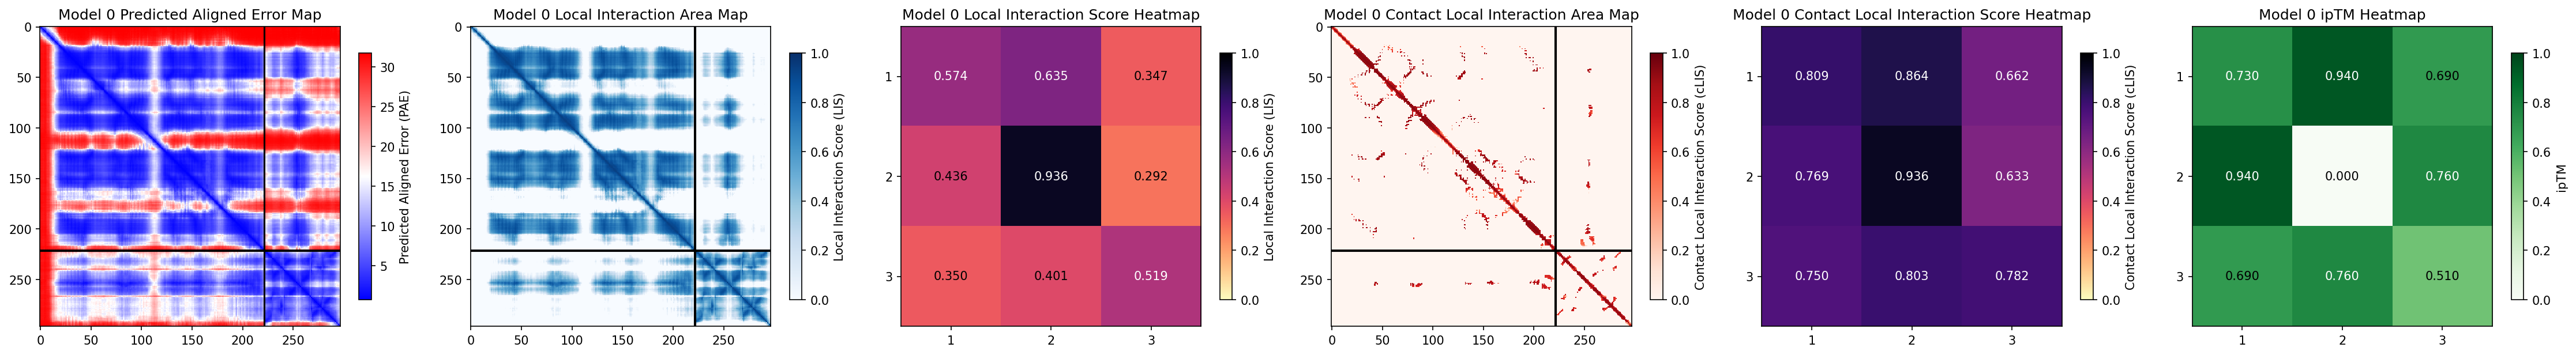

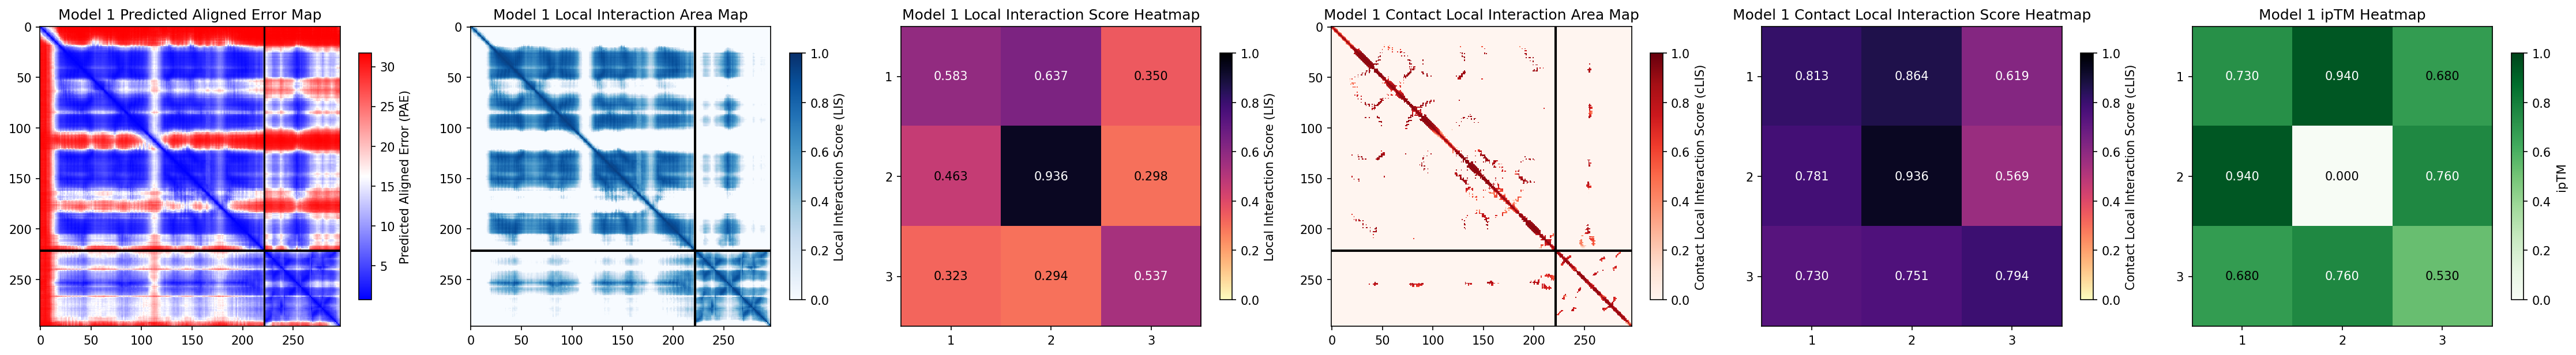

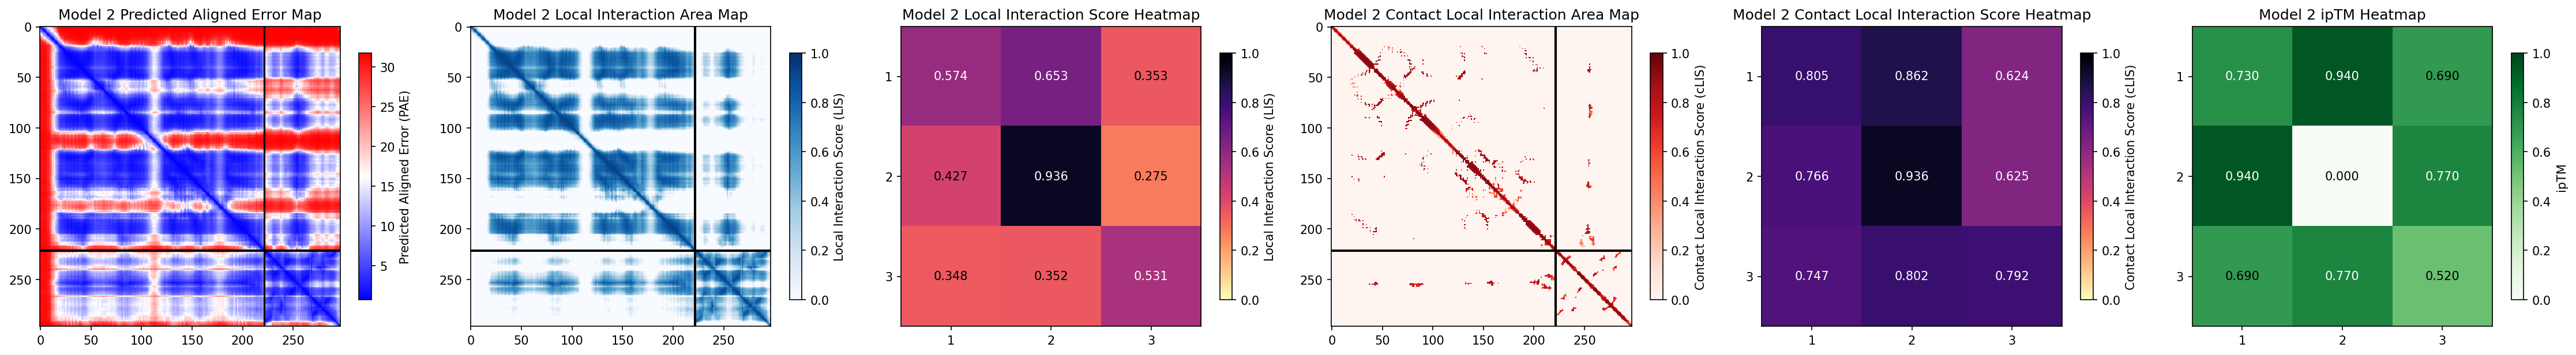

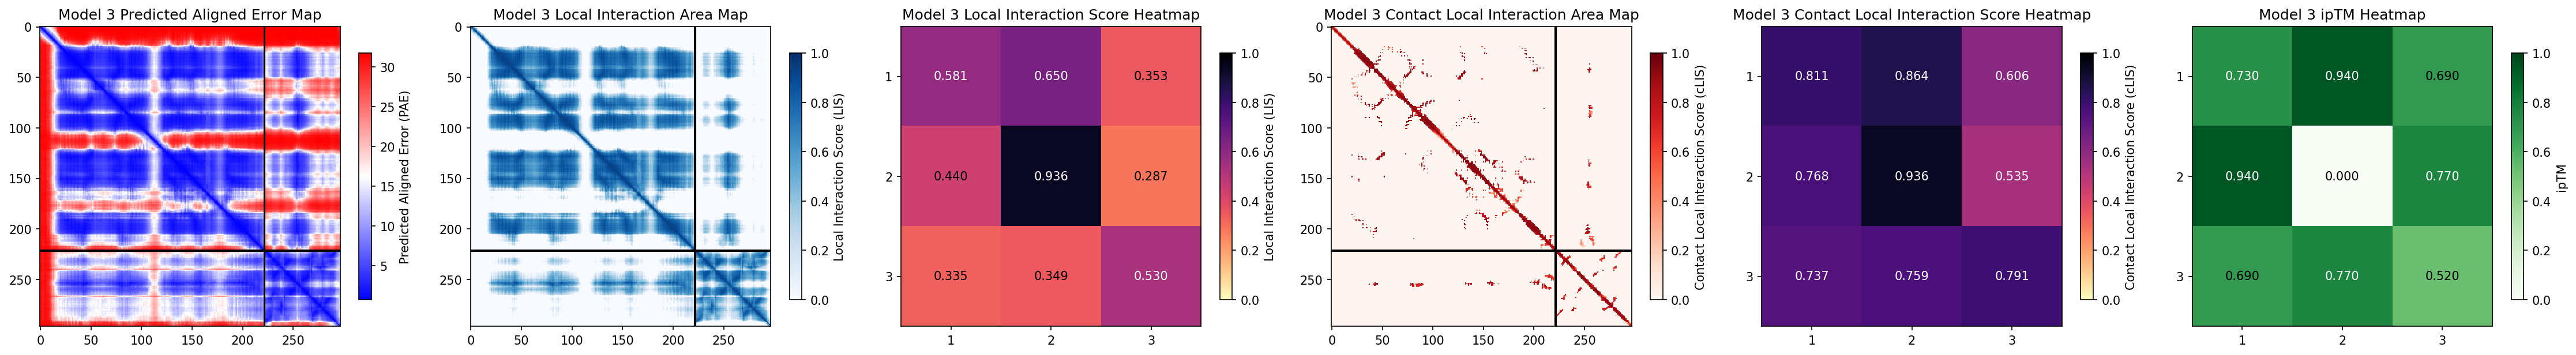

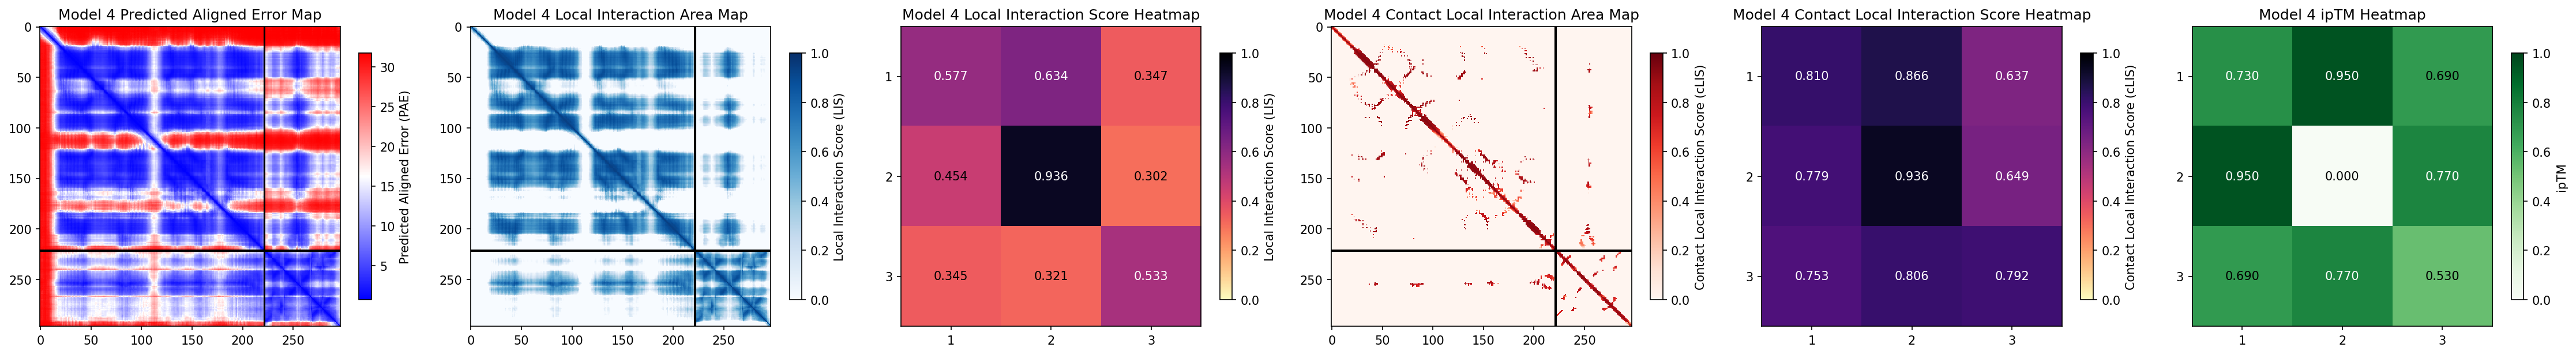

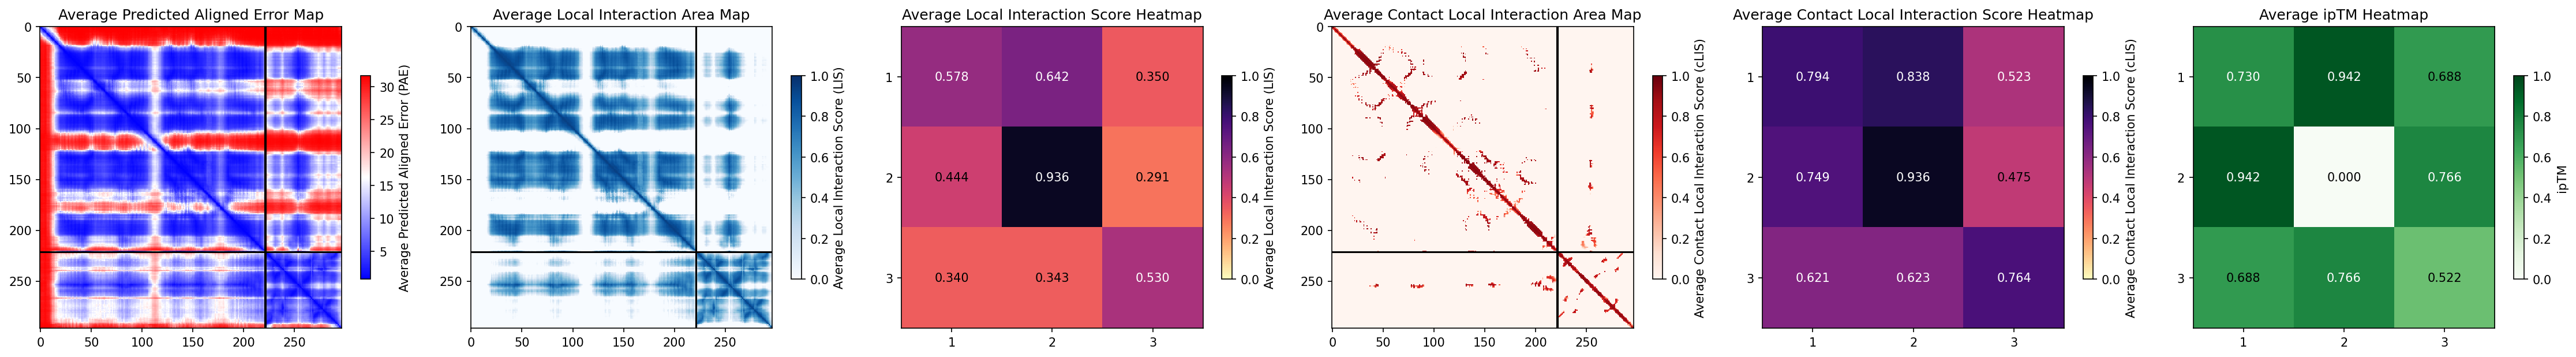

Results saved to:  /content/alphafold3/fold_protein_rna_ion_pdb_8aw3_without_protein_2_and_zn/fold_protein_rna_ion_pdb_8aw3_without_protein_2_and_zn_lis_analysis.csv
fold_protein_rna_ion_pdb_8aw3_without_protein_2_and_zn_lis_analysis.csv
Processed: /content/alphafold3/fold_protein_rna_ion_pdb_8aw3_without_protein_2_and_zn
                                          folder_name model_number  protein_1  \
0   fold_protein_rna_ion_pdb_8aw3_without_protein_...            0          1   
1   fold_protein_rna_ion_pdb_8aw3_without_protein_...            0          1   
2   fold_protein_rna_ion_pdb_8aw3_without_protein_...            0          1   
3   fold_protein_rna_ion_pdb_8aw3_without_protein_...            0          2   
4   fold_protein_rna_ion_pdb_8aw3_without_protein_...            0          2   
5   fold_protein_rna_ion_pdb_8aw3_without_protein_...            0          3   
6   fold_protein_rna_ion_pdb_8aw3_without_protein_...            1          1   
7   fold_protein_rna_ion_pdb

In [ ]:
#@title Plotting LIS results and saving LIS output

mpl.rcParams['figure.dpi'] = 150 # change this for high resolution output
pae_cutoff = 12  # Adjust based on your preference
distance_cutoff = 8  # Can be too short or too long, adjust based on your preference
result_save = "True"  # If you want to save the results to a CSV file, set this to "True". Otherwise, set this to "False"

# Assuming generate_json_paths and afm3_plot are already defined
if base_path:
    # Process each subdirectory
    json_files = generate_json_paths(base_path, number_of_models=5)
    for json_file in json_files:
        afm3_plot(json_file, pae_cutoff, distance_cutoff)  # Plotting individual models
    afm3_plot_average(json_files, pae_cutoff, distance_cutoff)  # Plotting average of all models
    df_interactions = afm3_plot_average_to_df(json_files, pae_cutoff, distance_cutoff, result_save)
    print(f"Processed: {base_path}")
    print(df_interactions)
else:
    print("No zip file was uploaded and extracted.")
